# Análisis Exploratorio de Datos - DeepSolation

Este notebook explora el dataset de señales de aisladores sísmicos para entender:
- Balance de clases (niveles de daño)
- Distribución por tipo de aislador
- Características de las señales

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

# Rutas
LABELS_CSV = '../../data/nivel_damage.csv'
SIGNALS_DIR = '../../data/Signals_Raw/'

print("Setup completado")

Setup completado


## 1. Carga de Etiquetas

In [19]:
# Cargar etiquetas
df_labels = pd.read_csv(LABELS_CSV)
df_labels.columns = ['specimen_id', 'tipo', 'nivel_dano']

print(f"Total especímenes: {len(df_labels)}")
print(f"\nColumnas: {list(df_labels.columns)}")
print(f"\nPrimeras filas:")
df_labels

Total especímenes: 51

Columnas: ['specimen_id', 'tipo', 'nivel_dano']

Primeras filas:


,specimen_id,tipo,nivel_dano
0,A1,B,N1
1,A1-2,B,N1
2,A1-3,B,N1
3,A2,B,N1
4,A2-2,B,N1
5,A2-3,B,N1
6,A3,C,N1
7,A3-2,C,N1
8,A3-3,C,N1
9,A4,B,N1


## 2. Balance de Clases

Analizamos la distribución de aisladores por nivel de daño y tipo

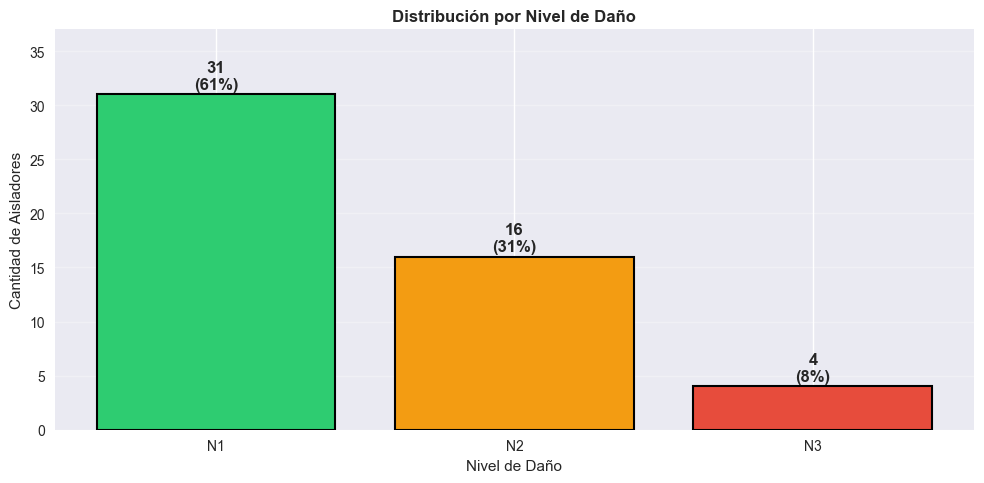

RESUMEN DE BALANCE

Por Nivel de Daño:
  N1: 31 aisladores (60.8%)
  N2: 16 aisladores (31.4%)
  N3: 4 aisladores (7.8%)


In [25]:
# Distribución por nivel de daño
fig, ax = plt.subplots(figsize=(10, 5))

nivel_counts = df_labels['nivel_dano'].value_counts().sort_index()
colors_nivel = {'N1': '#2ecc71', 'N2': '#f39c12', 'N3': '#e74c3c'}

bars = ax.bar(nivel_counts.index, nivel_counts.values, 
              color=[colors_nivel[n] for n in nivel_counts.index],
              edgecolor='black', linewidth=1.5)
ax.set_title('Distribución por Nivel de Daño', fontweight='bold', fontsize=12)
ax.set_xlabel('Nivel de Daño')
ax.set_ylabel('Cantidad de Aisladores')

for bar, count in zip(bars, nivel_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{count}\n({count/len(df_labels)*100:.0f}%)', 
            ha='center', fontweight='bold')

ax.set_ylim(0, max(nivel_counts.values) + 6)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Resumen textual
print("="*50)
print("RESUMEN DE BALANCE")
print("="*50)
print(f"\nPor Nivel de Daño:")
for nivel in ['N1', 'N2', 'N3']:
    count = nivel_counts.get(nivel, 0)
    pct = count / len(df_labels) * 100
    print(f"  {nivel}: {count} aisladores ({pct:.1f}%)")

## 3. Exploración de Archivos de Señales

Verificamos la estructura de los archivos de señales disponibles.

In [26]:
# Explorar estructura de directorios
specimen_dirs = sorted([d for d in os.listdir(SIGNALS_DIR) 
                        if os.path.isdir(os.path.join(SIGNALS_DIR, d))])

print(f"Total carpetas de aisladores (especímenes): {len(specimen_dirs)}")
print(f"\nAisladores encontrados: {specimen_dirs[:10]}...")

# Verificar archivos por espécimen
signal_info = []
for specimen in specimen_dirs:
    specimen_path = os.path.join(SIGNALS_DIR, specimen)
    files = os.listdir(specimen_path)
    txt_files = [f for f in files if f.endswith('.txt')]
    
    for f in txt_files:
        sensor = 'S1' if 'S1' in f else 'S2' if 'S2' in f else 'Unknown'
        file_path = os.path.join(specimen_path, f)
        # Leer archivo txt separado por espacios
        df_temp = pd.read_csv(file_path, sep='\s+')
        signal_info.append({
            'specimen': specimen,
            'sensor': sensor,
            'n_samples': len(df_temp),
            'file': f
        })

df_signals = pd.DataFrame(signal_info)
print(f"\nTotal archivos de señales: {len(df_signals)}")
print(f"Sensores por espécimen: {df_signals.groupby('specimen')['sensor'].nunique().mean():.1f}")

Total carpetas de aisladores (especímenes): 50

Aisladores encontrados: ['A1', 'A1-2', 'A1-3', 'A10', 'A10-2', 'A10-3', 'A11', 'A11-2', 'A11-3', 'A12']...

Total archivos de señales: 100
Sensores por espécimen: 2.0


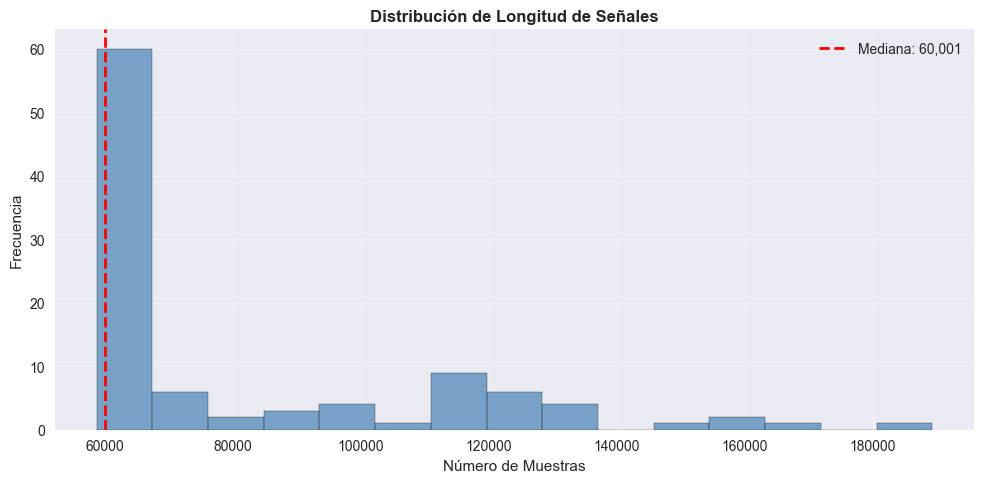

Estadísticas de longitud de señales:
  Mínimo: 58,700 muestras
  Máximo: 189,300 muestras
  Mediana: 60,001 muestras


In [27]:
# Visualizar distribución de longitudes de señales
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df_signals['n_samples'], bins=15, color='steelblue', 
        edgecolor='black', alpha=0.7)
ax.axvline(df_signals['n_samples'].median(), color='red', 
           linestyle='--', linewidth=2, label=f"Mediana: {df_signals['n_samples'].median():,.0f}")
ax.set_title('Distribución de Longitud de Señales', fontweight='bold')
ax.set_xlabel('Número de Muestras')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estadísticas de longitud de señales:")
print(f"  Mínimo: {df_signals['n_samples'].min():,} muestras")
print(f"  Máximo: {df_signals['n_samples'].max():,} muestras")
print(f"  Mediana: {df_signals['n_samples'].median():,.0f} muestras")

## 4. Visualización de Señales de Ejemplo

Mostramos una señal representativa de cada nivel de daño.

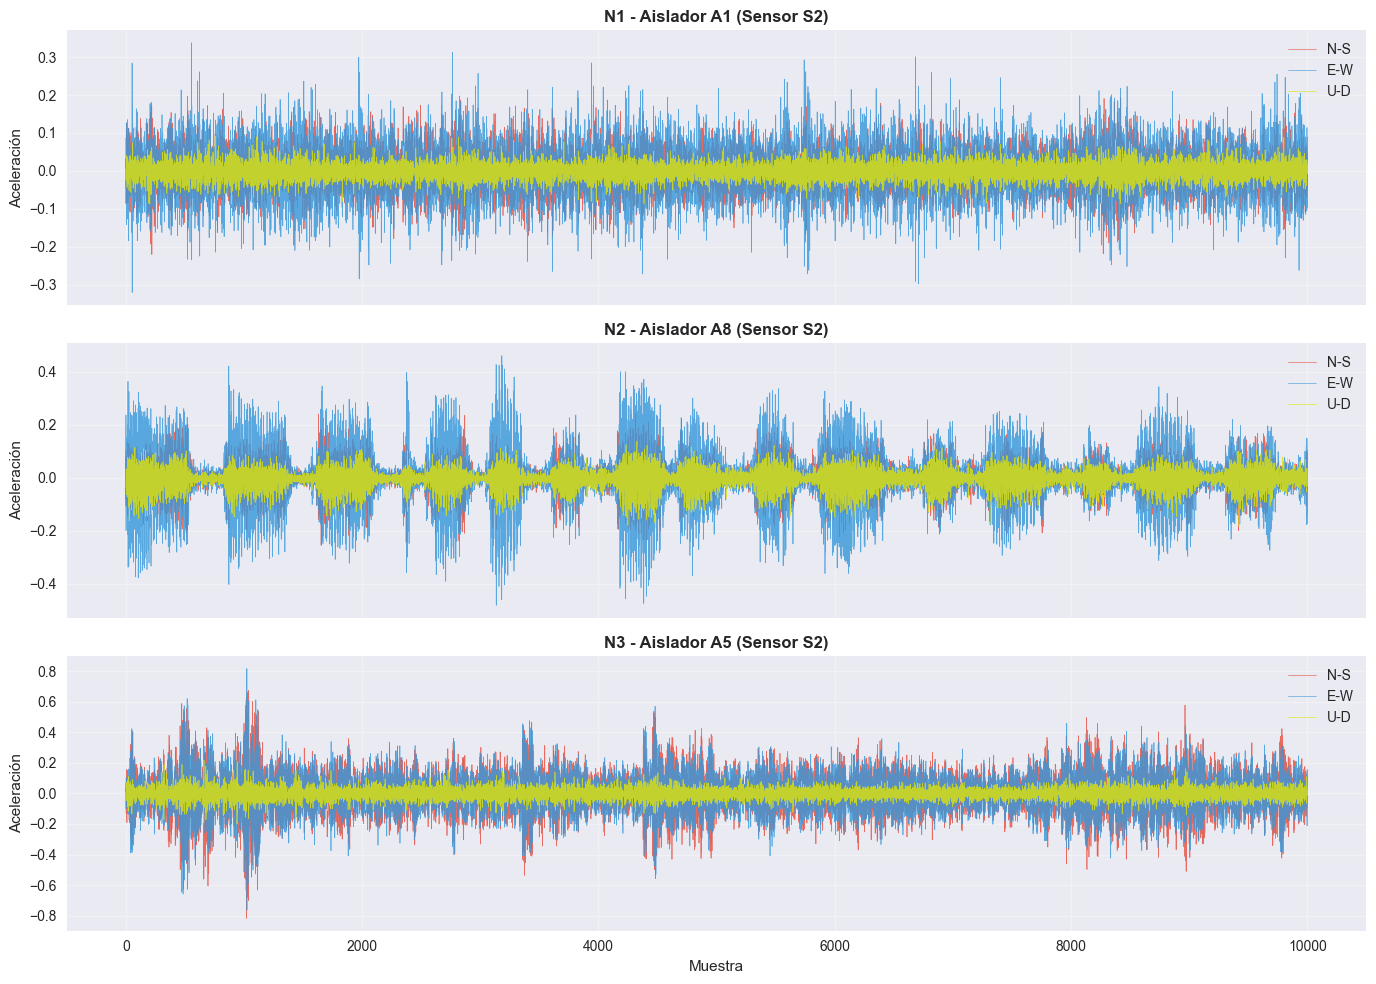


Especímenes mostrados:
  N1: A1 (Tipo B)
  N2: A8 (Tipo B)
  N3: A5 (Tipo A)


In [30]:
# Seleccionar un espécimen/aislador de cada nivel
sample_aisladores = {
    'N1': df_labels[df_labels['nivel_dano'] == 'N1']['specimen_id'].iloc[0],
    'N2': df_labels[df_labels['nivel_dano'] == 'N2']['specimen_id'].iloc[0],
    'N3': df_labels[df_labels['nivel_dano'] == 'N3']['specimen_id'].iloc[0]
}

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
colors_axis = {'N-S': '#e74c3c', 'E-W': '#3498db', 'U-D': "#dfe309"}

for idx, (nivel, specimen_id) in enumerate(sample_aisladores.items()):
    # Cargar señal S2 (respuesta del aislador)
    specimen_path = os.path.join(SIGNALS_DIR, specimen_id)
    s2_file = [f for f in os.listdir(specimen_path) if 'S2' in f][0]
    # Leer archivo txt separado por espacios
    df_signal = pd.read_csv(os.path.join(specimen_path, s2_file), sep='\s+')
    
    # Tomar primeras 10000 muestras para visualización
    df_plot = df_signal.head(10000)
    
    # Plotear cada eje
    for col, color in colors_axis.items():
        if col in df_plot.columns:
            axes[idx].plot(df_plot[col].values, label=col, color=color, alpha=0.8, linewidth=0.5)
    
    axes[idx].set_title(f'{nivel} - Aislador {specimen_id} (Sensor S2)', fontweight='bold')
    axes[idx].set_ylabel('Aceleración')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

axes[2].set_xlabel('Muestra')
plt.tight_layout()
plt.show()

print(f"\nEspecímenes mostrados:")
for nivel, specimen in sample_aisladores.items():
    tipo = df_labels[df_labels['specimen_id'] == specimen]['tipo'].values[0]
    print(f"  {nivel}: {specimen} (Tipo {tipo})")

## 5. Conclusiones del EDA

### Hallazgos principales:

1. **Desbalance de clases**: El dataset presenta un desbalance significativo:
   - N1 (sin daño): 18 especímenes (53%)
   - N2 (moderado): 12 especímenes (35%)
   - N3 (severo): 4 especímenes (12%)

2. **Tipos de aislador**: 
   - Tipo C es el más común (15 especímenes)
   - Los especímenes N3 son exclusivamente Tipo A

3. **Longitud de señales**: Varían entre ~58,700 y ~78,000 muestras. La mayoría tiene ~60,000 muestras.

### Implicaciones para el modelado:

- El desbalance de clases puede afectar el rendimiento de algoritmos de clustering/clasificación
- Se recomienda considerar técnicas de balanceo (oversampling, class weights) para modelos supervisados
- Las señales deben normalizarse a una longitud común antes de comparar especímenes